In [12]:
import torch
from PIL import Image
import os
from tqdm import tqdm
from torch.utils.data import Dataset

import torchvision.transforms as T
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [13]:
class FolderDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")

        if self.transform is not None:
            tensor_image = self.transform(image)

        return tensor_image, tensor_image

In [14]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.img_size = img_size
        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        # print(x.shape)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # print(x.shape)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # print(x.shape)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        # print(x.shape)
        return x

In [15]:
class ConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        # self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
#         self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
#         self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        # print(x.shape)
        x = self.deconv1(x)
        x = self.relu1(x)
        # print(x.shape)

        x = self.deconv2(x)
        x = self.relu2(x)
        # print(x.shape)

        x = self.deconv3(x)
        x = self.relu3(x)
        # print(x.shape)
        return x

In [16]:
IMG_PATH = "./imgset/"

IMG_HEIGHT = 512  # The images are already resized here
IMG_WIDTH = 512  # The images are already resized here

SEED = 42
TRAIN_RATIO = 0.75
VAL_RATIO = 1 - TRAIN_RATIO
SHUFFLE_BUFFER_SIZE = 100

LEARNING_RATE = 1e-3
EPOCHS = 2
TRAIN_BATCH_SIZE = 32  # Let's see, I don't have GPU, Google Colab is best hope
TEST_BATCH_SIZE = 32  # Let's see, I don't have GPU, Google Colab is best hope
FULL_BATCH_SIZE = 32

AUTOENCODER_MODEL_PATH = "baseline_autoencoder.pt"
ENCODER_MODEL_PATH = "baseline_encoder.pt"
DECODER_MODEL_PATH = "baseline_decoder.pt"
EMBEDDING_SHAPE = (1, 64, 64, 64)
# TEST_RATIO = 0.2

In [17]:
__all__ = ["train_step", "val_step", "create_embedding"]

import torch
import torch.nn as nn

def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):
    # device = "cuda"
    encoder.train()
    decoder.train()

    # print(device)

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()

        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)

        loss = loss_fn(dec_output, target_img)
        loss.backward()

        optimizer.step()

    return loss.item()

def val_step(encoder, decoder, val_loader, loss_fn, device):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            enc_output = encoder(train_img)
            dec_output = decoder(enc_output)

            loss = loss_fn(dec_output, target_img)

    return loss.item()

In [18]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [19]:
transforms = T.Compose([T.ToTensor()])
print("------------ Creating Dataset ------------")
full_dataset = FolderDataset(IMG_PATH, transforms)

train_size = int(TRAIN_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

print("------------ Dataset Created ------------")
print("------------ Creating DataLoader ------------")
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE
)

full_loader = torch.utils.data.DataLoader(
    full_dataset, batch_size=FULL_BATCH_SIZE
)

------------ Creating Dataset ------------
------------ Dataset Created ------------
------------ Creating DataLoader ------------


In [16]:
print("------------ Dataloader Cretead ------------")

# print(train_loader)
loss_fn = nn.MSELoss()

encoder = ConvEncoder()
decoder = ConvDecoder()

if torch.cuda.is_available():
    print("GPU Availaible moving models to GPU")
else:
    print("Moving models to CPU")

encoder.to(device)
decoder.to(device)

# print(device)

autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.AdamW(autoencoder_params, lr=LEARNING_RATE)

# early_stopper = utils.EarlyStopping(patience=5, verbose=True, path=)
max_loss = 9999

print("------------ Training started ------------")

for epoch in tqdm(range(EPOCHS)):
    train_loss = train_step(
        encoder, decoder, train_loader, loss_fn, optimizer, device=device
    )
    print(f"Epochs = {epoch}, Training Loss : {train_loss}")
    val_loss = val_step(
        encoder, decoder, val_loader, loss_fn, device=device
    )

    # Simple Best Model saving
    if val_loss < max_loss:
        print("Validation Loss decreased, saving new best model")
        torch.save(encoder.state_dict(), ENCODER_MODEL_PATH)
        torch.save(decoder.state_dict(), DECODER_MODEL_PATH)

    print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

print("Training Done")

------------ Dataloader Cretead ------------
Moving models to CPU
------------ Training started ------------


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Epochs = 0, Training Loss : 0.028736881911754608


 50%|██████████████████████                      | 1/2 [05:45<05:45, 345.87s/it]

Validation Loss decreased, saving new best model
Epochs = 0, Validation Loss : 0.017785727977752686
Epochs = 1, Training Loss : 0.0073742978274822235


100%|████████████████████████████████████████████| 2/2 [11:35<00:00, 347.67s/it]

Validation Loss decreased, saving new best model
Epochs = 1, Validation Loss : 0.005822803825139999
Training Done


In [43]:
embedding_dim = (1, 64, 64, 64)

In [44]:
def create_embedding(encoder, full_loader, embedding_dim, device):
    encoder.eval()
    embedding = torch.randn(embedding_dim)
    # print(embedding.shape)

    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            train_img = train_img.to(device)
            enc_output = encoder(train_img).cpu()
            # print(enc_output.shape)
            embedding = torch.cat((embedding, enc_output), 0)
            # print(embedding.shape)
    
    return embedding

In [45]:
embedding = create_embedding(encoder, full_loader, embedding_dim, device)

In [46]:
embedding.shape

torch.Size([4739, 64, 64, 64])

In [47]:
numpy_embedding = embedding.cpu().detach().numpy()

In [48]:
numpy_embedding.shape

(4739, 64, 64, 64)

In [49]:
num_images = numpy_embedding.shape[0]

In [50]:
flattened_embedding = numpy_embedding.reshape((num_images, -1))

In [51]:
flattened_embedding.shape

(4739, 262144)

In [52]:
import numpy as np
np.save("data_embedding_f.npy", flattened_embedding)

In [20]:
import torch
import numpy as np
import torch_model
from sklearn.neighbors import NearestNeighbors
import torchvision.transforms as T
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
def load_image_tensor(image_path, device):
    image_tensor = T.ToTensor()(Image.open(image_path))
    image_tensor = image_tensor.unsqueeze(0)
    print(image_tensor.shape)
    # input_images = image_tensor.to(device)
    return image_tensor

In [54]:
def compute_similar_images(image_path, num_images, embedding, device):
    image_tensor = load_image_tensor(image_path, device)
    # image_tensor = image_tensor.to(device)

    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()

    print(image_embedding.shape)

    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
    print(flattened_embedding.shape)

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()
    print(indices_list)
    return indices_list

In [59]:
def plot_similar_images(indices_list):
    indices = indices_list[0]
    for index in indices:
        img_name = str(index - 1) + ".jpg"
        img_path = os.path.join("./imgset/" + img_name)
        print(img_path)
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        plt.show()

In [56]:
TEST_IMAGE_PATH = "./imgset/4625.jpg"
NUM_IMAGES = 10
ENCODER_MODEL_PATH = "./baseline_encoder.pt"
DECODER_MODEL_PATH = "./baseline_decoder.pt"
EMBEDDING_PATH = "./data_embedding_f.npy"
EMBEDDING_SHAPE = (1, 256, 16, 16)

torch.Size([1, 3, 512, 512])
(1, 64, 64, 64)
(1, 262144)
[[3922, 2830, 2475, 166, 123, 850, 2121, 1767, 165, 2036]]
./imgset/3921.jpg


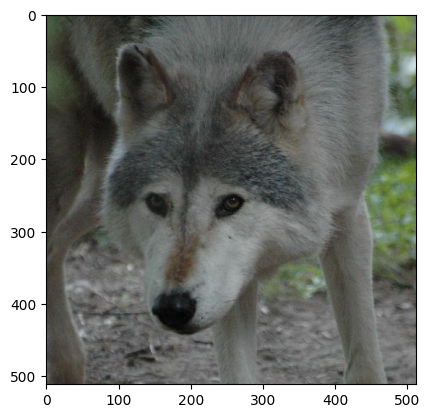

./imgset/2829.jpg


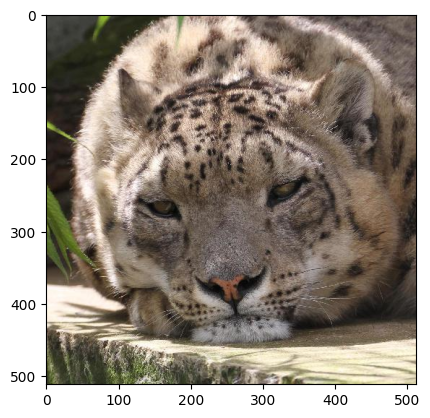

./imgset/2474.jpg


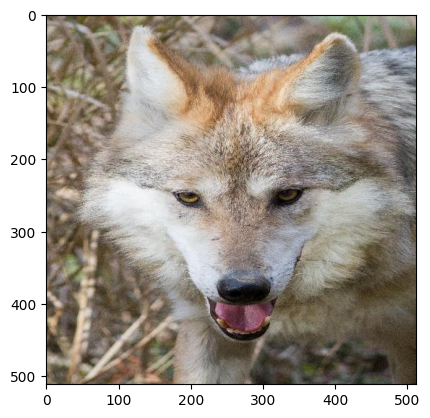

./imgset/165.jpg


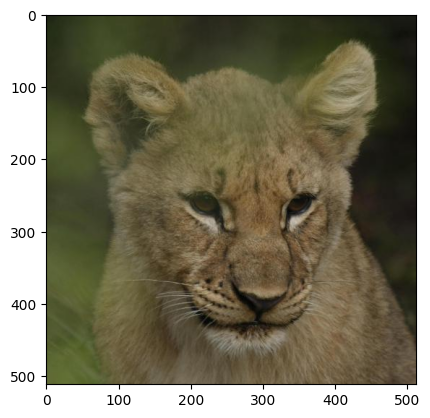

./imgset/122.jpg


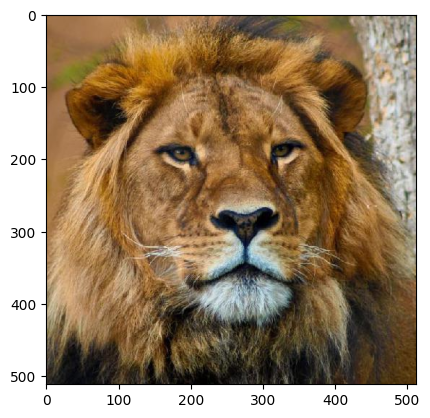

./imgset/849.jpg


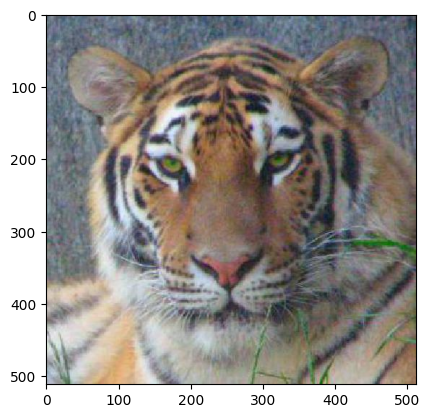

./imgset/2120.jpg


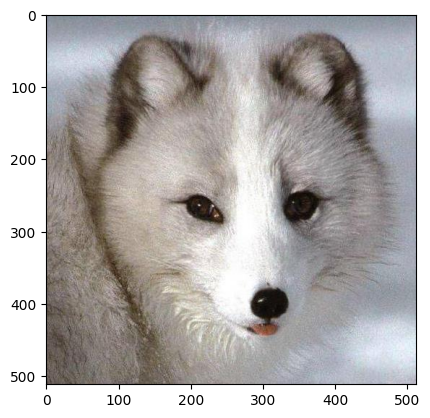

./imgset/1766.jpg


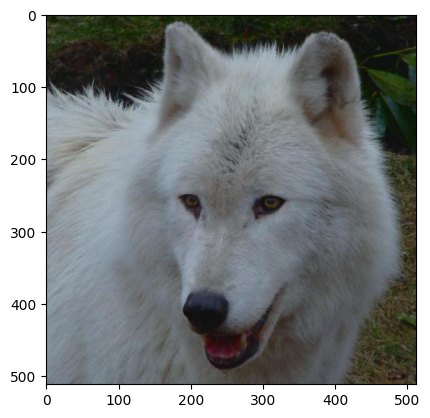

./imgset/164.jpg


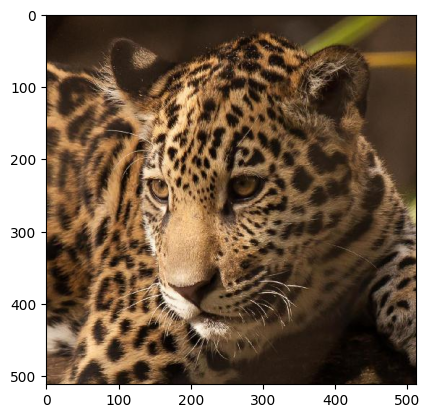

./imgset/2035.jpg


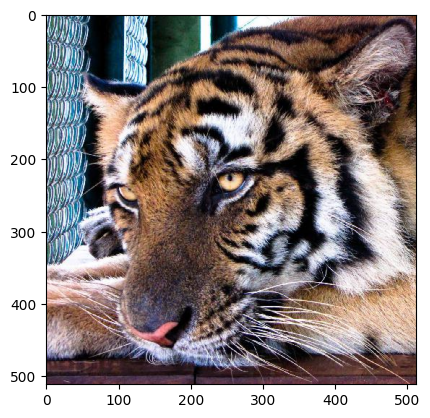

In [60]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder = ConvEncoder()

# Load the state dict of encoder
encoder.load_state_dict(torch.load(ENCODER_MODEL_PATH, map_location=device))
encoder.eval()
encoder.to(device)

# Loads the embedding
embedding = np.load(EMBEDDING_PATH)

indices_list = compute_similar_images(TEST_IMAGE_PATH, NUM_IMAGES, embedding, device)
plot_similar_images(indices_list)